In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

supermarket_df = pd.read_csv("完整数据.csv"
                             ,encoding="Windows-1252")
# 邮编缺失值过多，删除
supermarket_df.drop(columns="Postal Code", axis=0, inplace=True)

supermarket_df["Order Date"] = pd.to_datetime(supermarket_df["Order Date"], format="mixed")
supermarket_df["Ship Date"] = pd.to_datetime(supermarket_df["Ship Date"], format="mixed")
supermarket_df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,2011-01-01,2011-06-01,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.1400,35.46,Medium
1,22253,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.0360,9.72,Medium
2,48883,HU-2011-1220,2011-01-01,2011-05-01,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.6400,8.17,High
3,11731,IT-2011-3647632,2011-01-01,2011-05-01,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.0550,4.82,High
4,22255,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.7700,4.70,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,32593,CA-2014-115427,2014-12-31,2015-04-01,Standard Class,EB-13975,Erica Bern,Corporate,Fairfield,California,...,OFF-BI-10002103,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.904,2,0.2,4.5188,0.89,Medium
51286,47594,MO-2014-2560,2014-12-31,2015-05-01,Standard Class,LP-7095,Liz Preis,Consumer,Agadir,Souss-Massa-Draâ,...,OFF-WIL-10001069,Office Supplies,Binders,"Wilson Jones Hole Reinforcements, Clear",3.990,1,0.0,0.4200,0.49,Medium
51287,8857,MX-2014-110527,2014-12-31,2015-02-01,Second Class,CM-12190,Charlotte Melton,Consumer,Managua,Managua,...,OFF-LA-10004182,Office Supplies,Labels,"Hon Color Coded Labels, 5000 Label Set",26.400,3,0.0,12.3600,0.35,Medium
51288,6852,MX-2014-114783,2014-12-31,2015-06-01,Standard Class,TD-20995,Tamara Dahlen,Consumer,Juárez,Chihuahua,...,OFF-LA-10000413,Office Supplies,Labels,"Hon Legal Exhibit Labels, Alphabetical",7.120,1,0.0,0.5600,0.20,Medium


In [3]:
%pip install statsmodels
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 训练前预处理

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import numpy as np

# 按月份分开

sales_total = supermarket_df.set_index(pd.DatetimeIndex(supermarket_df["Order Date"]))
sales_total = sales_total.groupby(pd.Grouper(freq='MS'))["Sales"].sum()

sales_total.index.freq = "MS"
sales_total

Order Date
2011-01-01    138241.30042
2011-02-01    134969.94086
2011-03-01    171455.59372
2011-04-01    128833.47034
2011-05-01    148146.72092
2011-06-01    189338.43966
2011-07-01    162034.69756
2011-08-01    219223.49524
2011-09-01    255237.89698
2011-10-01    204675.07846
2011-11-01    214934.29386
2011-12-01    292359.96752
2012-01-01    162800.89338
2012-02-01    152661.15144
2012-03-01    201608.72784
2012-04-01    187469.96192
2012-05-01    218960.16042
2012-06-01    249289.77172
2012-07-01    174394.02808
2012-08-01    271669.66086
2012-09-01    256567.85308
2012-10-01    239321.09904
2012-11-01    270723.05356
2012-12-01    291972.33306
2013-01-01    206459.19582
2013-02-01    191062.77216
2013-03-01    230547.79468
2013-04-01    233181.34844
2013-05-01    304509.96336
2013-06-01    341162.34370
2013-07-01    223642.65664
2013-08-01    323876.60716
2013-09-01    326897.27044
2013-10-01    270121.87570
2013-11-01    383039.21248
2013-12-01    371245.40880
2014-01-01    268

## 检查加法模型/乘法模型

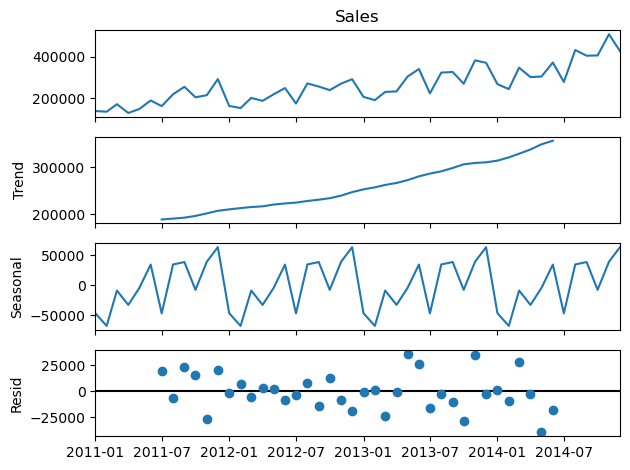

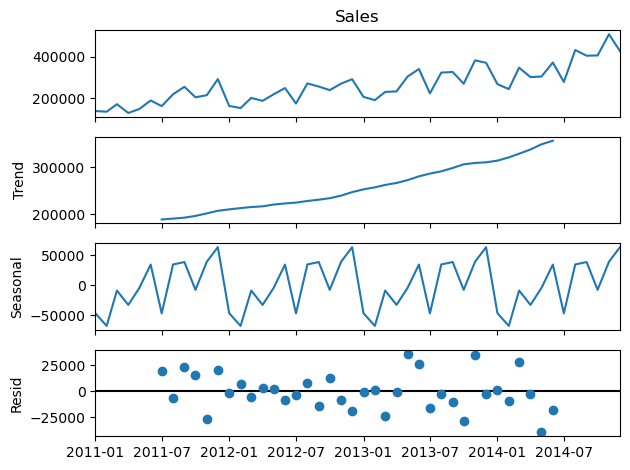

In [5]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

add_results = seasonal_decompose(sales_total, model="additive")
mul_results = seasonal_decompose(sales_total, model="multipliative")
add_results.plot()


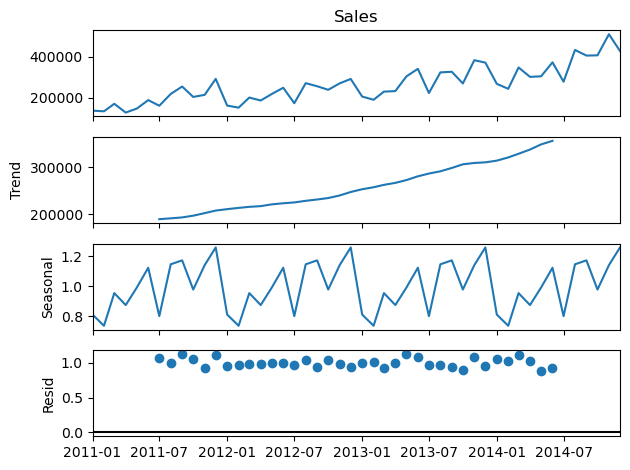

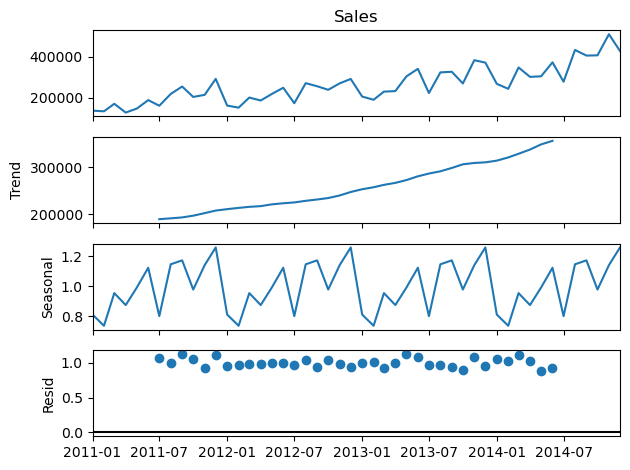

In [6]:
mul_results.plot()

In [7]:
add_resid = add_results.resid.dropna()
mul_resid = mul_results.resid.dropna()
add_acf_total = np.sum(np.square(acf(add_resid)))
mul_acf_total = np.sum(np.square(acf(mul_resid)))
add_acf_total, mul_acf_total, add_acf_total < mul_acf_total

(1.3325077202425215, 1.2540181752744441, False)

## 随机网格搜索

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm_joblib import tqdm_joblib
import random
import warnings
from multiprocessing import cpu_count, Pool
from joblib import Parallel
from joblib import delayed

warnings.filterwarnings('ignore')
# 网格搜索
params = {
  "p": [0,1,2,3,4],
  "d": [0,1,2,3,4],
  "q": [0,1,2,3,4],
  "P": [0,1,2,3,4],
  "D": [0,1,2,3,4],
  "Q": [0,1,2,3,4]
}

result_matrix = pd.DataFrame(columns=["Parameters", "MSE", "MAE" ,"AIC" , "HQIC","Log-Likelihood"])

def train(param):
  p,d,q,P,D,Q = param
  try:
    model = SARIMAX(sales_total, order=(p,d,q), seasonal_order=(P, D, Q,12), trend="ct", enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return (f"({p}, {d}, {q})x({P}, {D}, {Q}, 12)", results.mse, results.mae, results.aic, results.hqic, results.llf)
  except:
    return (f"({p}, {d}, {q})x({P}, {D}, {Q}, 12)", np.nan, np.nan, np.nan, np.nan, np.nan)
    

def grid_search(params):
  keys, values = zip(*params.items())
  param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
  random_param_combinations = random.sample(param_combinations, k=200)
  tasks = (delayed(train)(list(param.values())) for param in param_combinations)
  executor = Parallel(n_jobs=cpu_count()) 
  with tqdm_joblib(desc="Grid Search", total=len(param_combinations)) as progress_bar:
    results = executor(tasks)
  for result in results:
    result_matrix.loc[len(result_matrix.index)] = result


grid_search(params)

result_matrix.sort_values(by="AIC")

Grid Search:   0%|          | 0/15625 [00:00<?, ?it/s]

,Parameters,MSE,MAE,AIC,HQIC,Log-Likelihood
2520,"(0, 4, 0)x(0, 4, 0, 12)",NaN,NaN,6.000000e+00,NaN,0.000000e+00
20,"(0, 0, 0)x(0, 4, 0, 12)",NaN,NaN,6.000000e+00,NaN,0.000000e+00
1270,"(0, 2, 0)x(0, 4, 0, 12)",NaN,NaN,6.000000e+00,NaN,0.000000e+00
1895,"(0, 3, 0)x(0, 4, 0, 12)",NaN,NaN,6.000000e+00,NaN,0.000000e+00
645,"(0, 1, 0)x(0, 4, 0, 12)",NaN,NaN,6.000000e+00,NaN,0.000000e+00
...,...,...,...,...,...,...
12765,"(4, 0, 2)x(0, 3, 0, 12)",1.510113e+06,1.159146e+06,5.553058e+15,5.553058e+15,-2.776529e+15
14515,"(4, 3, 1)x(0, 3, 0, 12)",1.170897e+06,9.006141e+05,2.770705e+16,2.770705e+16,-1.385352e+16
9260,"(2, 4, 4)x(0, 2, 0, 12)",1.968558e+07,1.418907e+07,2.237573e+17,2.237573e+17,-1.118787e+17
1515,"(0, 2, 2)x(0, 3, 0, 12)",7.005169e+06,6.014925e+06,4.107484e+17,4.107484e+17,-2.053742e+17


In [102]:
result_matrix
result_matrix.dropna().sort_values(by="MAE")

,Parameters,MSE,MAE,AIC,HQIC,Log-Likelihood
7380,"(2, 1, 4)x(0, 1, 0, 12)",4.557069e+04,3.163062e+04,726.147700,730.181996,-354.073850
13505,"(4, 1, 3)x(0, 1, 0, 12)",4.513626e+04,3.173773e+04,748.785000,753.459441,-364.392500
13502,"(4, 1, 3)x(0, 0, 2, 12)",4.203463e+04,3.188761e+04,475.165282,477.083321,-225.582641
128,"(0, 0, 1)x(0, 0, 3, 12)",4.162873e+04,3.210686e+04,253.999008,251.675462,-119.999504
3252,"(1, 0, 1)x(0, 0, 2, 12)",4.205909e+04,3.250394e+04,542.895858,544.694976,-264.447929
...,...,...,...,...,...,...
6751,"(2, 0, 4)x(0, 0, 1, 12)",1.609268e+77,2.351722e+76,20.000000,24.674441,0.000000
7901,"(2, 2, 3)x(1, 0, 1, 12)",1.851632e+79,2.700244e+78,20.000000,24.482551,0.000000
15401,"(4, 4, 3)x(1, 0, 1, 12)",5.940532e+83,8.634489e+82,24.000000,28.887218,0.000000
9126,"(2, 4, 3)x(0, 0, 1, 12)",8.622650e+86,1.253393e+86,18.000000,21.665414,0.000000


In [107]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, P, D, Q = 2,1,4,0,1,0

model = SARIMAX(sales_total, order=(p,d,q), seasonal_order=(P,D,Q,12), trend="ct",enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results_restricted = results.apply(sales_total, refit=False)
pred = results_restricted.get_prediction(start="2011-01-01", end="2018-01-01")
data = pd.concat([sales_total, pred.predicted_mean], axis=1).reset_index()

import altair as alt

base = alt.Chart(data).encode(x="index:T")
alt.layer(
base.mark_line(color="skyblue").encode(y="Sales:Q"),
base.mark_line(color="red").encode(y="predicted_mean:Q")
).properties(
  width=900
).show()

print(results.aic)

alt.LayerChart(...)

726.1477001825069
